### Machine Learning Project: Identify fraud from Enron Email

In [12]:
#### Firstly, let's load the necessary data and packages. 
#### I am going to create a dataframe in pandas and then with the use of numpy arrays and matplotlib visualize it.

import sys
import pickle
sys.path.append("../tools/")
import random


from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.grid_search import GridSearchCV
from time import time

import pandas as pd
get_ipython().magic(u'matplotlib inline')
from matplotlib import pyplot as plt

#### Let's load my dictionary providede by Udacity
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#### Exploring the dataset

In [13]:
#### Let's check the type of my dataset, as we see it's a dictionary
type(data_dict)

dict

In [14]:
#### By converting the dictionary into a dataframe with pandas it will be easier and faster to work with it:
enron_dataf = pd.DataFrame.from_records(list(data_dict.values()))

In [15]:
#### Previosly the index were numbers, but it's easier to set them as names of employees series:
employees = pd.Series(list(data_dict.keys()))
enron_dataf.set_index(employees, inplace=True)
enron_dataf.head()

#### Coerce numeric values into floats or ints; also change NaN to zero:
enron_dataf = enron_dataf.apply(lambda x : pd.to_numeric(x, errors = 'coerce')).copy().fillna(0)
enron_dataf.head()

bonus  deferral_payments  deferred_income  \
METTS MARK         600000.0                0.0              0.0   
BAXTER JOHN C     1200000.0          1295738.0       -1386055.0   
ELLIOTT STEVEN     350000.0                0.0        -400729.0   
CORDES WILLIAM R        0.0                0.0              0.0   
HANNON KEVIN P    1500000.0                0.0       -3117011.0   

                  director_fees  email_address  exercised_stock_options  \
METTS MARK                  0.0            0.0                      0.0   
BAXTER JOHN C               0.0            0.0                6680544.0   
ELLIOTT STEVEN              0.0            0.0                4890344.0   
CORDES WILLIAM R            0.0            0.0                 651850.0   
HANNON KEVIN P              0.0            0.0                5538001.0   

                  expenses  from_messages  from_poi_to_this_person  \
METTS MARK         94299.0           29.0                     38.0   
BAXTER JOHN C      11200.0            0.0                      0.0   
ELLIOTT STEVEN     78552.0            0.0                      0.0   
CORDES WILLIAM R       0.0           12.0                     10.0   
HANNON KEVIN P     34039.0           32.0                     32.0   

                  from_this_person_to_poi        ...          \
METTS MARK                            1.0        ...           
BAXTER JOHN C                         0.0        ...           
ELLIOTT STEVEN                        0.0        ...           
CORDES WILLIAM R                      0.0        ...           
HANNON KEVIN P                       21.0        ...           

                  long_term_incentive      other    poi  restricted_stock  \
METTS MARK                        0.0     1740.0  False          585062.0   
BAXTER JOHN C               1586055.0  2660303.0  False         3942714.0   
ELLIOTT STEVEN                    0.0    12961.0  False         1788391.0   
CORDES WILLIAM R                  0.0        0.0  False          386335.0   
HANNON KEVIN P              1617011.0    11350.0   True          853064.0   

                  restricted_stock_deferred    salary  \
METTS MARK                              0.0  365788.0   
BAXTER JOHN C                           0.0  267102.0   
ELLIOTT STEVEN                          0.0  170941.0   
CORDES WILLIAM R                        0.0       0.0   
HANNON KEVIN P                          0.0  243293.0   

                  shared_receipt_with_poi  to_messages  total_payments  \
METTS MARK                          702.0        807.0       1061827.0   
BAXTER JOHN C                         0.0          0.0       5634343.0   
ELLIOTT STEVEN                        0.0          0.0        211725.0   
CORDES WILLIAM R                     58.0        764.0             0.0   
HANNON KEVIN P                     1035.0       1045.0        288682.0   

                  total_stock_value  
METTS MARK                 585062.0  
BAXTER JOHN C            10623258.0  
ELLIOTT STEVEN            6678735.0  
CORDES WILLIAM R          1038185.0  
HANNON KEVIN P            6391065.0  

[5 rows x 21 columns]

In [16]:
print enron_dataf.columns

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')


In [17]:
#### Let's see what features we have about the Enron's CEO:

enron_dataf.loc['SKILLING JEFFREY K']

bonus                            5.6e+06
deferral_payments                      0
deferred_income                        0
director_fees                          0
email_address                          0
exercised_stock_options        1.925e+07
expenses                           29336
from_messages                        108
from_poi_to_this_person               88
from_this_person_to_poi               30
loan_advances                          0
long_term_incentive             1.92e+06
other                              22122
poi                                 True
restricted_stock             6.84367e+06
restricted_stock_deferred              0
salary                       1.11126e+06
shared_receipt_with_poi             2042
to_messages                         3627
total_payments               8.68272e+06
total_stock_value            2.60937e+07
Name: SKILLING JEFFREY K, dtype: object

In [18]:
print enron_dataf.keys()

Index([u'bonus', u'deferral_payments', u'deferred_income', u'director_fees',
       u'email_address', u'exercised_stock_options', u'expenses',
       u'from_messages', u'from_poi_to_this_person',
       u'from_this_person_to_poi', u'loan_advances', u'long_term_incentive',
       u'other', u'poi', u'restricted_stock', u'restricted_stock_deferred',
       u'salary', u'shared_receipt_with_poi', u'to_messages',
       u'total_payments', u'total_stock_value'],
      dtype='object')


In [19]:
#### As we see there are 146 people in our dataset. Only 18 of them are POI  - Persons of Interest
enron_dataf['poi'].value_counts()

False    128
True      18
Name: poi, dtype: int64

In [262]:
### DETECTING OUTLIERS 

#### Let's visualize the salaries and bonuses of ppl in Enron,that's a good way to find outliers

plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == True],enron_dataf["bonus"][enron_dataf["poi"] == True], color = 'r',
           label = "POI")
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == False],enron_dataf["bonus"][enron_dataf["poi"] == False],color = 'b',
           label = "Not-POI")
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary & bonus")
plt.legend(loc='upper left')
plt.show() 

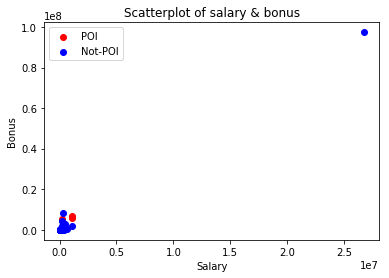

In [20]:
#### Let's visualize the salaries and bonuses of ppl in Enron,that's a good way to find outliers

plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == True],enron_dataf["bonus"][enron_dataf["poi"] == True], color = 'r',
           label = "POI")
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == False],enron_dataf["bonus"][enron_dataf["poi"] == False],color = 'b',
           label = "Not-POI")
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary & bonus")
plt.legend(loc='upper left')
plt.show() 

In [21]:
#### Dropping column 'email_address':
enron_dataf.drop('email_address', axis = 1, inplace = True)
#### Deleting 'THE TRAVEL AGENCY IN THE PARK':
enron_dataf.drop('THE TRAVEL AGENCY IN THE PARK', axis = 0, inplace = True)
#### Deleting the row 'Total':
enron_dataf.drop('TOTAL', axis = 0, inplace = True)

In [22]:
enron_dataf.shape

(144, 20)

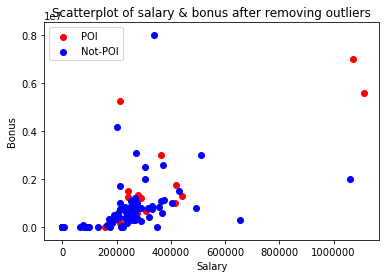

In [23]:
#### Now we can plot again the salary&bonus graph after short cleaning of the dataset:
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == True],enron_dataf["bonus"][enron_dataf["poi"] == True], color = 'r',
           label = "POI")
plt.scatter(enron_dataf["salary"][enron_dataf["poi"] == False],enron_dataf["bonus"][enron_dataf["poi"] == False],color = 'b',
           label = "Not-POI")
    
plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.title("Scatterplot of salary & bonus after removing outliers")
plt.legend(loc='upper left')
plt.show() 


In [51]:
# Created two new features in ratios:
enron_dataf['new_feature_from_messages_to_poi_ratio'] = enron_dataf['from_poi_to_this_person']/enron_dataf['from_messages']
enron_dataf['new_feature_to_messages_from_this_person_to_poi_ratio'] = enron_dataf['from_this_person_to_poi']/enron_dataf['to_messages']

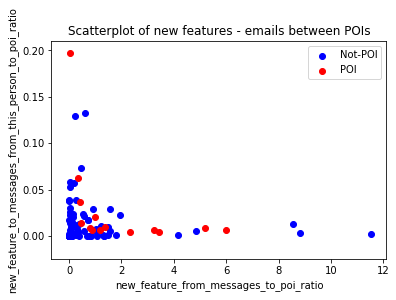

In [52]:
plt.scatter(enron_dataf['new_feature_from_messages_to_poi_ratio'][enron_dataf['poi'] == False],
            enron_dataf['new_feature_to_messages_from_this_person_to_poi_ratio'][enron_dataf['poi'] == False],
            color = 'b', label = 'Not-POI')

plt.scatter(enron_dataf['new_feature_from_messages_to_poi_ratio'][enron_dataf['poi'] == True],
            enron_dataf['new_feature_to_messages_from_this_person_to_poi_ratio'][enron_dataf['poi'] == True],
            color = 'r', label = 'POI')

    
plt.xlabel('new_feature_from_messages_to_poi_ratio')
plt.ylabel('new_feature_to_messages_from_this_person_to_poi_ratio')
plt.title("Scatterplot of new features - emails between POIs")
plt.legend(loc='upper right')
plt.show() 


In [25]:
#Clean all 'inf' values which we got if the person's from_messages = 0
enron_dataf = enron_dataf.replace('inf', 0)
enron_dataf = enron_dataf.fillna(0)
# Converting the above modified dataframe to a dictionary
enron_dict = enron_dataf.to_dict('index')

In [26]:
# To make it easier with further exploration let's set my dataset to a new dictionary
my_dataset = enron_dict

In [27]:
# I've decided to use quite many features as following 19, added the features creatd by me too.
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'expenses', 
                 'restricted_stock_deferred', 'restricted_stock', 'deferred_income','total_payments',
                  'from_poi_to_this_person', 'from_this_person_to_poi', 'to_messages', 
                 'from_messages', 'shared_receipt_with_poi', 'exercised_stock_options',
                'total_stock_value', 'restricted_stock', 'new_feature_from_messages_to_poi_ratio', 
                 'new_feature_to_messages_from_this_person_to_poi_ratio']

In [28]:
# These two lines extract the features specified in features_list
# and extract them from data_dict, returning a numpy array

data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [29]:
# Deploying feature selection
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.3, 
                                                                                             random_state=42)

# Stratified ShuffleSplit cross-validator
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=100, test_size=0.3,random_state = 42)

# I decided to use Feature Scaling, so here it's the import of necesary modules:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Features for pipeline 
# scaling
scaler = MinMaxScaler()

# selection
skb = SelectKBest(f_classif)

# PCA
pca = PCA()

In [30]:
# First it will be Gaussian Naive Bayes using PCA
from sklearn.naive_bayes import GaussianNB
clf_gnb = GaussianNB()

pipeline = Pipeline(steps = [("scaling", scaler),("SKB", skb), ("PCA",pca), ("NaiveBayes",clf_gnb)])
param_grid = {"SKB__k":[4,5,6,7,8,9,10,11,12],   
              "PCA__n_components":[2,3,4],
              "PCA__whiten":[True]}

grid = GridSearchCV(pipeline, param_grid, verbose = 0, cv = sss, scoring = 'f1')

t0 = time()

grid.fit(features, labels)
print "training time: ", round(time()-t0, 3), "s"

# GridSearchCV and StratifiedShuffleSplit 
clf = grid.best_estimator_

t0 = time()

prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

print "Accuracy of GaussianNB classifer (using PCA) is  : ",accuracy_score(labels_test, prediction)
print "Precision of GaussianNB classifer (using PCA) is : ",precision_score(prediction, labels_test)
print "Recall of GaussianNB classifer (using PCA) is    : ",recall_score(prediction, labels_test)
print "f1-score of GaussianNB classifer (using PCA) is  : ",f1_score(prediction, labels_test)

C:\Users\Marcela\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


training time:  68.716 s
testing time:  0.002 s
Accuracy of GaussianNB classifer (using PCA) is  :  0.883720930233
Precision of GaussianNB classifer (using PCA) is :  0.4
Recall of GaussianNB classifer (using PCA) is    :  0.5
f1-score of GaussianNB classifer (using PCA) is  :  0.444444444444


#### GB gave me a very good accuracy: 0.8837 and the recall 0.4

In [31]:
# use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    #make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

In [39]:
# simulate splitting a dataset of 25 observations into 5 folds
from sklearn.cross_validation import KFold
kf = KFold(25, n_folds=5, shuffle=False)

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], data[1]))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


In [32]:
# Second classifier will be a DecisionTree
from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print 'accuracy before tuning ', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"

accuracy before tuning  0.808510638298
Decision tree algorithm time: 0.048 s


#### The result is slightly worse with accuracy of 0.8085 and with recall of 0.048

In [48]:
# Now we will try Naive Bayes for prediction
t0 = time()

clf = GaussianNB()
clf.fit(features_train, labels_train)
pred = clf.predict(features_test)
accuracy = accuracy_score(pred,labels_test)
print accuracy

print "NB algorithm time:", round(time()-t0, 3), "s"

0.765957446809
NB algorithm time: 0.004 s


In [35]:
# use manual tuning parameter min_samples_split
t0 = time()
clf = DecisionTreeClassifier(min_samples_split=5)
clf = clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("done in %0.3fs" % (time() - t0))

acc=accuracy_score(labels_test, pred)

print "Validating algorithm:"
print "accuracy after tuning = ", acc

# function for calculation ratio of true positives
# out of all positives (true + false)
print 'precision = ', precision_score(labels_test,pred)

# function for calculation ratio of true positives
# out of true positives and false negatives
print 'recall = ', recall_score(labels_test,pred)

done in 0.003s
Validating algorithm:
accuracy after tuning =  0.872340425532
precision =  0.333333333333
recall =  0.2


In [40]:
# Another classifer is a Decision Tree,
# it gives certainly better accuracy

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

t0 = time()

clf = DecisionTreeClassifier()
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
pred= clf.predict(features_test)
print 'accuracy', score

print "Decision tree algorithm time:", round(time()-t0, 3), "s"

accuracy 0.829787234043
Decision tree algorithm time: 0.007 s


In [45]:
# dump your classifier, dataset and features_list so
# anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "w") )
pickle.dump(data_dict, open("my_dataset.pkl", "w") )
pickle.dump(features_list, open("my_feature_list.pkl", "w") )

In [36]:
from sklearn.neighbors import KNeighborsClassifier

clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"
print "Accuracy of KNN classifer is  : ",accuracy_score(labels_test, prediction)

testing time:  2076.257 s
Accuracy of DT classifer is  :  0.808510638298


In [37]:
clf.fit(features_train, labels_train)
prediction = clf.predict(features_test)
print "testing time: ", round(time()-t0, 3), "s"

testing time:  2160.532 s
